In [1]:
import torch
import pickle
import numpy as np
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
# custom libraries
import sys, os
print(f"{sys.executable = }")
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../../spaths'))
import spaths
from src import systems, dmaps, nets

sys.executable = '/Users/pzielinski/opt/anaconda3/envs/sf_nets/bin/python'


# Four dimensional system with rotation and quadratic perturbation

In [5]:
path = '../data/RQP4'
if not os.path.exists(path):
    os.makedirs(path)
simdat = {}  # to store simulation details

In [6]:
# seed setting
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3, size=10**4);  # warm up of RNG
simdat['seed'] = seed

# solver
em = spaths.EulerMaruyama(rng)
simdat['solver'] = em

## Sample trajectory

In [7]:
# corresponding system
rqp4_sde = systems.rqp4_sde
rqp4_dat = systems.rqp4_dat

In [8]:
dt = .1 * rqp4_dat['tsep']
x0 = [0.0, 0.0, 0.0, 0.0]
tspan = (0.0, 160)
simdat['dt'] = dt
simdat['x0'] = x0
simdat['tspan'] = tspan

In [9]:
ini = np.array([x0]) #spaths.make_ens(x0, y0)
sol = em.solve(rqp4_sde, ini, tspan, dt)
print(f"{sol.p.shape = }")

sol.p.shape = (1, 40002, 4)


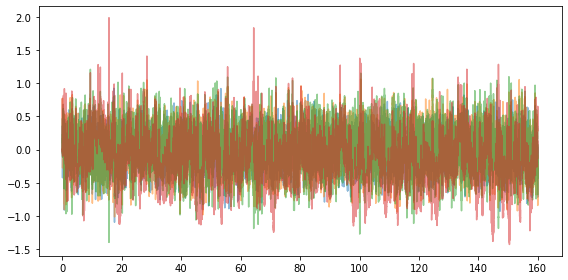

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
for f in sol.p[0].T:
    ax.plot(sol.t, f, alpha=.5)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Local noise cloud visualization

In [11]:
t_idx = 300
burst_size = 10**4
point_rep = np.repeat(sol.x[t_idx], burst_size, axis=0)
burst_ens = em.burst(rqp4_sde, point_rep, (0.0, 1), dt)
norm_ens = burst_ens - np.mean(burst_ens, axis=0)
print(f"{norm_ens.shape = }")

norm_ens.shape = (10000, 4)


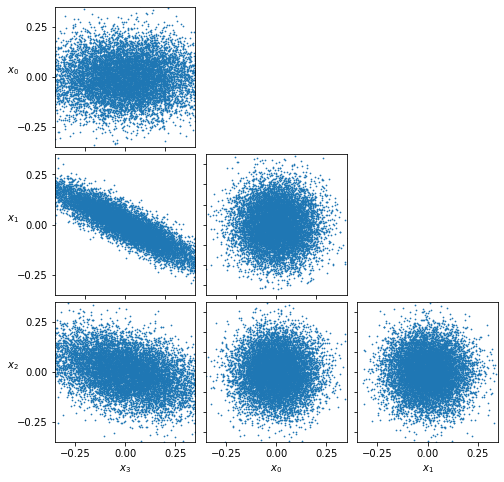

In [12]:
fig = plt.figure(figsize=(8,8))
gs = GridSpec(3, 3, figure=fig, hspace=0.05, wspace=0.05)

for n, coord in enumerate(norm_ens.T[:-1]):
    for m in range(n+1):
        ax = fig.add_subplot(gs[n, m])
#         ax.set_title(f"{n}, {m-1}")
        ax.scatter(norm_ens[:,m-1], coord, s=0.5)
        ax.set_xlim([-0.35, 0.35])
        ax.set_ylim([-0.35, 0.35])
        ax.set_aspect("equal")
        if n == 2:
            ax.set_xlabel(f"$x_{(m-1) % 4}$")
            ax.set_xticks([-.25, 0.0, +.25])
        else:
            ax.set_xticklabels([])
        if m == 0:
            ax.set_ylabel(f"$x_{n}$", rotation=0)
            ax.set_yticks([-.25, 0.0, +.25])
        else:
            ax.set_yticklabels([])

plt.show(fig)
plt.close(fig)

## Generate data

In [13]:
# we skip first few samples and from the rest take only part
t_data = sol.t[100::3]

In [14]:
data = np.squeeze(sol(t_data)).astype(dtype=np.float32)  # TODO: use as sol(tt).p[0] with sol(tt) giving a view
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (13301, 4)
data.dtype = dtype('float32')


In [15]:
burst_size = 10**4
covs = dmaps.ln_covs(data, rqp4_sde, em, burst_size, dt)
print(f"{covs.shape = }")
print(f"{covs.dtype = }")

covs.shape = (13301, 4, 4)
covs.dtype = dtype('float32')


In [16]:
data_t = torch.from_numpy(data).float()
covi_t = torch.pinverse(torch.tensor(covs).float(), rcond=1e-10)

## Split and save

In [17]:
train_nsam = int(len(data) * 0.7)
test_nsam = int(len(data) * 0.3)
rest = len(data) - train_nsam - test_nsam

In [18]:
from sklearn.model_selection import train_test_split
data_train, data_test, covi_train, covi_test = train_test_split(data_t, covi_t, test_size=0.33, random_state=42)

In [21]:
type(data_test)

torch.Tensor

In [23]:
torch.save((data_train, covi_train), f"{path}/train.pt")
torch.save((data_test, covi_test), f"{path}/test.pt")

In [17]:
dataset = nets.SimpleLabeledDataset(data_t, covi_t)
train_dataset, valid_dataset, _ = torch.utils.data.random_split(dataset, (train_nsam, valid_nsam, rest))

In [18]:
print(f"{len(train_dataset) = }")
print(f"{len(valid_dataset) = }")

len(train_dataset) = 9310
len(valid_dataset) = 3990


In [19]:
torch.save(train_dataset, "../data/rqp4/train.pt")
torch.save(valid_dataset, "../data/rqp4/valid.pt")

In [20]:
torch.save(simdat, "../data/rqp4/simdat.pt")